# Opinion Dynamics

In [1]:
!which python

/home/mattiapggioli/bookdealer-recommendation-network/.venv/bin/python


In [2]:
!python --version

Python 3.8.14


In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import random
import seaborn as sns
import tikzplotlib

## Network generation: using books in common as link between booksellers

In [5]:
df = pd.read_csv('data/bd-recommendations.csv')

In [6]:
df['consigliato-da']

0        81/libreria-tasso, 60/a-tutto-libro, 55/libris...
1        39/la-confraternita-delluva-libreria-indipende...
2        168/magia-del-fumetto, 486/lotta-libreria, 306...
3        51/il-ponte-sulla-dora, 116/lettera22, 433/lib...
4        285/libreria-fogola-pisa, 512/libreria-di-donn...
                               ...                        
20621                                41/libreria-zabarella
20622                                41/libreria-zabarella
20623                                41/libreria-zabarella
20624                                41/libreria-zabarella
20625    39/la-confraternita-delluva-libreria-indipendente
Name: consigliato-da, Length: 20626, dtype: object

In [7]:
# Convert str to list
df['consigliato-da'] = [str(bookdealer).split(', ') for bookdealer in df['consigliato-da']]
# Get bookdealer ids
recommendations = [recommendation for recommendations in df['consigliato-da'] for recommendation in recommendations]
bookdealers = list(set(recommendations))

In [8]:
books = list(df['consigliato-da'])
shared_books = list()

for bookstores in books:
    if len(bookstores) > 1:
        shared_books += list(itertools.combinations(bookstores, 2))

In [9]:
len(shared_books)

44783

In [10]:
edges = list()

for shared_book in list(set(shared_books)):
    bookdealer1 = bookdealers.index(shared_book[0])
    bookdealer2 = bookdealers.index(shared_book[1])
    weight = shared_books.count(shared_book)
    edges.append((bookdealer1, bookdealer2, weight))

In [11]:
edge_list = pd.DataFrame(columns=['Source', 'Target', 'Weight'], data=edges)

In [12]:
G = nx.from_pandas_edgelist(edge_list[edge_list['Weight']>1], 'Source', 'Target', ['Weight'])

In [13]:
edge_list.to_csv('data/booksellers-edge.csv')

In [14]:
nodes = list(G.nodes) 

## Network analysis

In [15]:
nx.info(G)

'Graph with 417 nodes and 7066 edges'

In [16]:
nx.is_connected(G)

True

In [17]:
nx.density(G)

0.08146559675336654

In [18]:
edge_list['Weight'].describe()

count    22984.000000
mean         1.948442
std          2.514769
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
Name: Weight, dtype: float64

In [19]:
average_degree = 2*G.number_of_edges() / float(G.number_of_nodes())
print(average_degree)

33.88968824940048


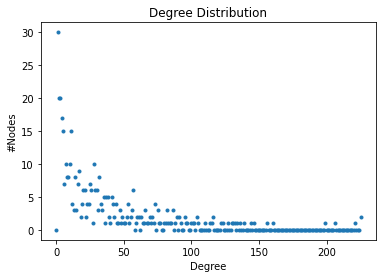

In [20]:
hist = nx.degree_histogram(G)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
#plt.loglog()
plt.show()

In [21]:
nx.diameter(G)

4

In [22]:
nx.average_clustering(G)

0.6242282222770644

In [23]:
nodes_by_degree = sorted([(node, G.degree[node]) for node in nodes], 
                         key=lambda t: t[1],
                         reverse=True)

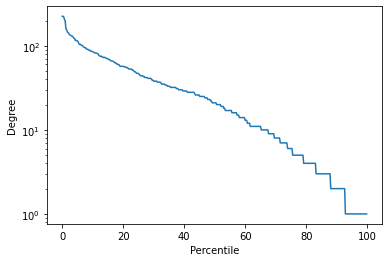

In [24]:
fig, ax = plt.subplots()
ax = sns.lineplot(x=[count*100/len(nodes_by_degree) for count,node in enumerate(nodes_by_degree)], 
                  y=[node[1] for node in nodes_by_degree])
ax.set_xlabel('Percentile')
ax.set_ylabel('Degree')
ax.set_yscale('log')
plt.show()

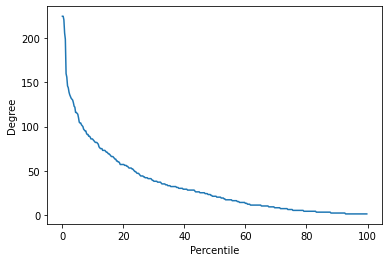

In [25]:
fig, ax = plt.subplots()
ax = sns.lineplot(x=[count*100/len(nodes_by_degree) for count,node in enumerate(nodes_by_degree)], 
                  y=[node[1] for node in nodes_by_degree])
ax.set_xlabel('Percentile')
ax.set_ylabel('Degree')
plt.show()

## Opinion Dynamics: Discrete Opinion models

In [26]:
import ndlib
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.opinions as op
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution

In [27]:
# Generate complete graph for comparision
complete = nx.complete_graph(G.number_of_nodes())

In [28]:
infected_nodes1 = random.sample(nodes,round(len(nodes)/2))
infected_nodes2 = [node[0] for node in nodes_by_degree if node[1] > 50]
infected_nodes3 = [node[0] for node in nodes_by_degree if node[1] < 10]

In [29]:
len(infected_nodes2)/len(nodes_by_degree)

0.23501199040767387

In [30]:
len(infected_nodes3)/len(nodes_by_degree)

0.3237410071942446

In [31]:
infnod_configs = [infected_nodes1, infected_nodes2, infected_nodes3]

In [32]:
models = dict()

In [33]:
IT = 2000
EX = 10

### Voter Model

In [34]:
model = 'voter'

In [35]:
simulations = dict()
for count, config in enumerate(infnod_configs, start=1):
    simulations[model+str(count)] = {'nodes': config}

models[model] = simulations

In [36]:
def execute_voter_simulation(graph, infected_nodes, executions=EX, iterations=IT, processes=4):
    # Set model
    model = op.VoterModel(graph)
    # Configure model
    config = mc.Configuration()
    config.add_model_initial_configuration('Infected', infected_nodes)    
    model.set_initial_status(config)
    # Simulate multiple executions
    trends = multi_runs(model, execution_number=executions, iteration_number=iterations, infection_sets=None, nprocesses=processes)
    return model, trends

In [37]:
for simulation in models[model].keys():    
    # Execute simulation for configuration
    simulation_result = execute_voter_simulation(graph=G, infected_nodes=models[model][simulation]['nodes'])
    models[model][simulation]['model'] = simulation_result[0]
    models[model][simulation]['trends'] = simulation_result[1]
    # Execute simulation on complete graph for respective configuration    
    simulation_result = execute_voter_simulation(graph=complete, infected_nodes=models[model][simulation]['nodes'])
    models[model][simulation]['cmp_model'] = simulation_result[0]
    models[model][simulation]['cmp_trends'] = simulation_result[1]

In [38]:
def visualize_trends(simulation, model_name, save=False):
    viz = DiffusionTrendComparison([simulation['model'],  simulation['cmp_model']], 
                                   [simulation['trends'], simulation['cmp_trends']])
    if save:
        print(f'Saving {model_name}')
        viz.plot(f'plots/opinion_dynamics/{model_name}.pdf')
    else:        
        print(model_name)
        viz.plot()

In [39]:
# convert list to iterator
iterator_simulations = iter(models[model].keys())

voter1


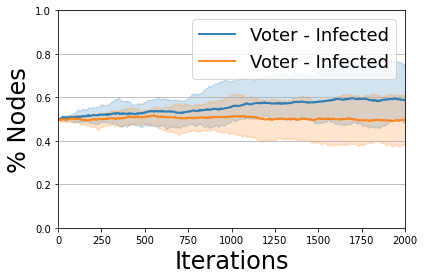

In [40]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

voter2


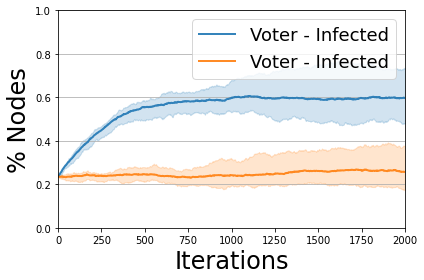

In [41]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

voter3


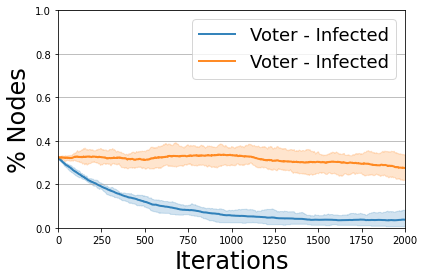

In [42]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

### Majority Rule

In [43]:
model = 'majority'

In [44]:
simulations = dict()
for count, config in enumerate(infnod_configs, start=1):
    simulations[model+str(count)] = {'nodes': config}

models[model] = simulations

In [45]:
def execute_majority_simulation(graph, infected_nodes, executions=EX, iterations=IT, processes=4):
    # Set model
    model = op.MajorityRuleModel(graph)
    # Configure model
    config = mc.Configuration()
    config.add_model_initial_configuration('Infected', infected_nodes)
    config.add_model_parameter('q', 10)    
    model.set_initial_status(config)
    # Simulate multiple executions
    trends = multi_runs(model, execution_number=executions, iteration_number=iterations, infection_sets=None, nprocesses=processes)
    return model, trends

In [46]:
for simulation in models[model].keys():    
    # Execute simulation for configuration
    simulation_result = execute_majority_simulation(graph=G, infected_nodes=models[model][simulation]['nodes'])
    models[model][simulation]['model'] = simulation_result[0]
    models[model][simulation]['trends'] = simulation_result[1]
    # Execute simulation on complete graph for respective configuration    
    simulation_result = execute_majority_simulation(graph=complete, infected_nodes=models[model][simulation]['nodes'])
    models[model][simulation]['cmp_model'] = simulation_result[0]
    models[model][simulation]['cmp_trends'] = simulation_result[1]

In [47]:
# convert list to iterator
iterator_simulations = iter(models[model].keys())

majority1


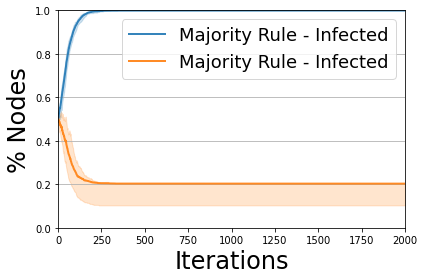

In [48]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

majority2


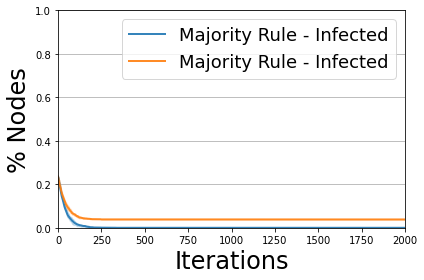

In [49]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

majority3


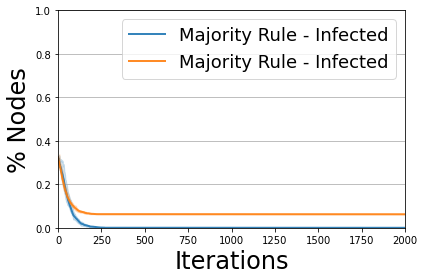

In [50]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

### Sznajd

In [51]:
model = 'sznajd'

In [52]:
simulations = dict()
for count, config in enumerate(infnod_configs, start=1):
    simulations[model+str(count)] = {'nodes': config}

models[model] = simulations

In [53]:
def execute_sznajd_simulation(graph, infected_nodes, executions=EX, iterations=IT, processes=4):
    # Set model
    model = op.SznajdModel(G)
    # Configure model
    config = mc.Configuration()
    config.add_model_initial_configuration('Infected', infected_nodes)        
    model.set_initial_status(config)
    # Simulate multiple executions
    trends = multi_runs(model, execution_number=executions, iteration_number=iterations, infection_sets=None, nprocesses=processes)
    return model, trends

In [54]:
for simulation in models[model].keys():    
    # Execute simulation for configuration
    simulation_result = execute_sznajd_simulation(graph=G, infected_nodes=models[model][simulation]['nodes'])
    models[model][simulation]['model'] = simulation_result[0]
    models[model][simulation]['trends'] = simulation_result[1]
    # Execute simulation on complete graph for respective configuration    
    simulation_result = execute_sznajd_simulation(graph=complete, infected_nodes=models[model][simulation]['nodes'])
    models[model][simulation]['cmp_model'] = simulation_result[0]
    models[model][simulation]['cmp_trends'] = simulation_result[1]

In [55]:
# convert list to iterator
iterator_simulations = iter(models[model].keys())

sznajd1


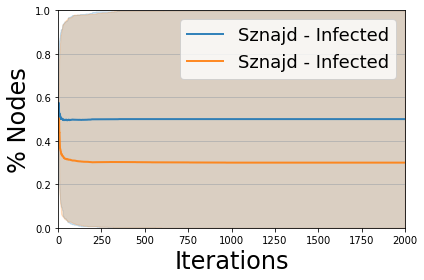

In [56]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

sznajd2


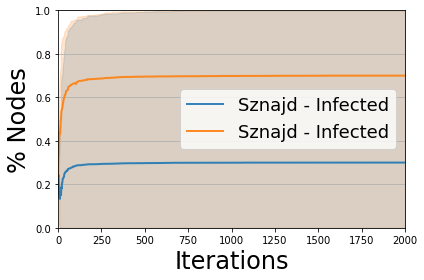

In [57]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

sznajd3


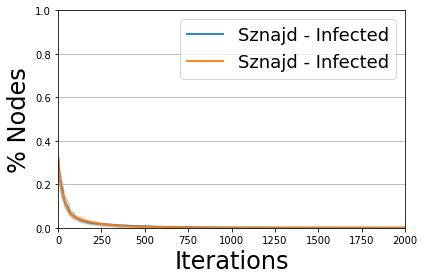

In [58]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

### Q-Voter

In [59]:
model = 'q-voter'

In [60]:
simulations = dict()
for count, config in enumerate(infnod_configs, start=1):
    simulations[model+str(count)] = {'nodes': config}

models[model] = simulations

In [61]:
def execute_qvoter_simulation(graph, infected_nodes, executions=EX, q=5, iterations=IT, processes=4):
    # Set model
    model = op.QVoterModel(G)
    # Configure model
    config = mc.Configuration()
    config.add_model_initial_configuration('Infected', infected_nodes)
    config.add_model_parameter("q", q)
    model.set_initial_status(config)
    # Simulate multiple executions
    trends = multi_runs(model, execution_number=executions, iteration_number=iterations, infection_sets=None, nprocesses=processes)
    return model, trends

In [62]:
for simulation in models[model].keys():    
    # Execute simulation for configuration
    simulation_result = execute_qvoter_simulation(graph=G, infected_nodes=models[model][simulation]['nodes'])
    models[model][simulation]['model'] = simulation_result[0]
    models[model][simulation]['trends'] = simulation_result[1]
    # Execute simulation on complete graph for respective configuration    
    simulation_result = execute_qvoter_simulation(graph=complete, infected_nodes=models[model][simulation]['nodes'])
    models[model][simulation]['cmp_model'] = simulation_result[0]
    models[model][simulation]['cmp_trends'] = simulation_result[1]

In [63]:
# convert list to iterator
iterator_simulations = iter(models[model].keys())

q-voter1


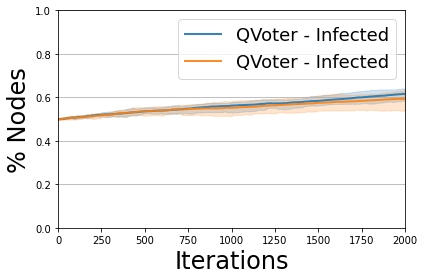

In [64]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

q-voter2


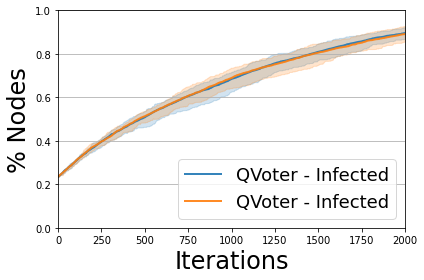

In [65]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

q-voter3


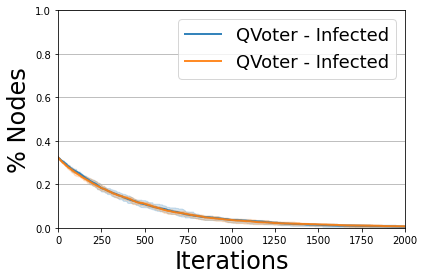

In [66]:
current_model = next(iterator_simulations)
visualize_trends(models[model][current_model], current_model)

In [67]:
last_q = round(average_degree)+1

q_variation2 = dict()
for i in range(1,last_q):
    simulation_result = execute_qvoter_simulation(graph=G, infected_nodes=infnod_configs[1], q=i)
    q_variation2[i] = simulation_result
    
q_variation3 = dict()
for i in range(1,last_q):
    simulation_result = execute_qvoter_simulation(graph=G, infected_nodes=infnod_configs[2], q=i)
    q_variation3[i] = simulation_result

# Visualisation

In [68]:
# Create the list to compare the algorithms for each initial configuration of infected nodes
# Each element in list is a df, designed to be plotted as lineplot
model_comp = dict()
for configuration in ['1','2','3']:
    # Every list represents a column in df
    timepoint_col = list()
    percentage_col = list()
    model_col = list()
    for model in models.keys():        
        # Iterate trough execution for specified model and configuration        
        for execution in models[model][model+configuration]['trends']:
            for timepoint, value in enumerate(execution['trends']['node_count'][1]):
                # Add timepoint to list (x)
                timepoint_col.append(timepoint)
                # Compute infected node percentage at timepoint t
                try:
                    tot = value+execution['trends']['node_count'][0][timepoint]                    
                    percentage = round(value*100/tot,2)
                except ZeroDivisionError:
                    percentage = 0                 
                # Add percentage to list (y)
                percentage_col.append(percentage)
                # Add current algorithm to list (hue)
                model_col.append(model)
    # Create df for current configuration
    df_conf = pd.DataFrame(zip(timepoint_col, percentage_col, model_col), 
                           columns=['timepoint','percentage','model'])
    model_comp[f'od-{configuration}'] = df_conf

In [69]:
def visualize_model_trends(df2plot, file_name=None):
    fig, ax = plt.subplots()
    ax = sns.lineplot(data=df2plot, x="timepoint", y="percentage", hue="model")
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('% Book A selection')
    ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
    if file_name:
        tikzplotlib.save(f"plots/opinion-dynamics/{file_name}.tex")
    plt.show()

In [70]:
# convert list to iterator
dfs2plot = iter(list(model_comp.keys()))

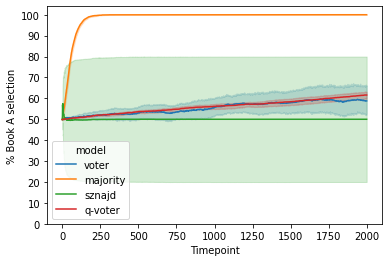

In [71]:
curr_df2plot = model_comp[next(dfs2plot)]
visualize_model_trends(curr_df2plot)

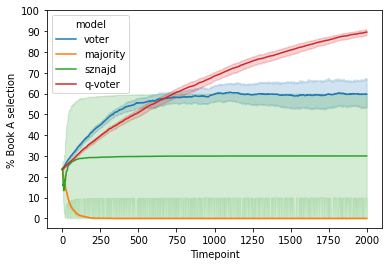

In [72]:
curr_df2plot = model_comp[next(dfs2plot)]
visualize_model_trends(curr_df2plot)

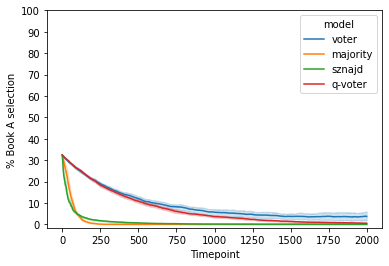

In [73]:
curr_df2plot = model_comp[next(dfs2plot)]
visualize_model_trends(curr_df2plot)

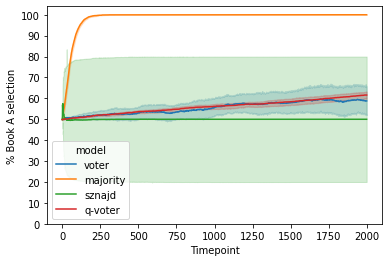

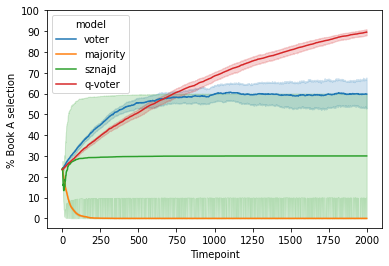

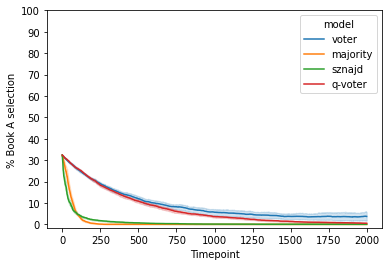

In [74]:
for plot2save in model_comp.keys():
    visualize_model_trends(model_comp[plot2save], file_name=plot2save)

In [75]:
timepoint_col = list()
percentage_col = list()
q_col = list()
for q in q_variation2.keys():    
    for execution in q_variation2[q][1]:        
        for timepoint, value in enumerate(execution['trends']['node_count'][1]):            
            timepoint_col.append(timepoint)
            # Compute infected node percentage at timepoint t
            try:
                tot = value+execution['trends']['node_count'][0][timepoint]                    
                percentage = round(value*100/tot,2)
            except ZeroDivisionError:
                percentage = 0                 
            # Add percentage to list (y)
            percentage_col.append(percentage)
            # Add current algorithm to list (hue)
            q_col.append(q)
df_q = pd.DataFrame(zip(timepoint_col, percentage_col, q_col), 
                    columns=['timepoint','percentage','q'])

In [76]:
df_q = df_q.groupby(['q', 'timepoint']).mean().reset_index()

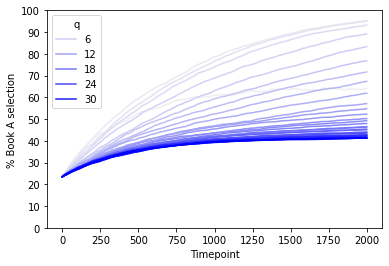

In [77]:
fig, ax = plt.subplots()
ax = sns.lineplot(data=df_q, x="timepoint", y="percentage", hue='q', palette='light:b')
ax.set_xlabel('Timepoint')
ax.set_ylabel('% Book A selection')
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

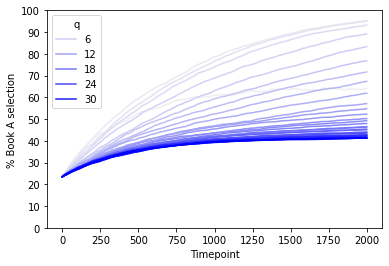

In [78]:
fig, ax = plt.subplots()
ax = sns.lineplot(data=df_q, x="timepoint", y="percentage", hue='q', palette='light:b')
ax.set_xlabel('Timepoint')
ax.set_ylabel('% Book A selection')
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
tikzplotlib.save("plots/opinion-dynamics/q-voter-variation.tex")

In [79]:
timepoint_col = list()
percentage_col = list()
q_col = list()
for q in q_variation3.keys():    
    for execution in q_variation3[q][1]:        
        for timepoint, value in enumerate(execution['trends']['node_count'][1]):            
            timepoint_col.append(timepoint)
            # Compute infected node percentage at timepoint t
            try:
                tot = value+execution['trends']['node_count'][0][timepoint]                    
                percentage = round(value*100/tot,2)
            except ZeroDivisionError:
                percentage = 0                 
            # Add percentage to list (y)
            percentage_col.append(percentage)
            # Add current algorithm to list (hue)
            q_col.append(q)
df_q = pd.DataFrame(zip(timepoint_col, percentage_col, q_col), 
                    columns=['timepoint','percentage','q'])

In [80]:
df_q = df_q.groupby(['q', 'timepoint']).mean().reset_index()

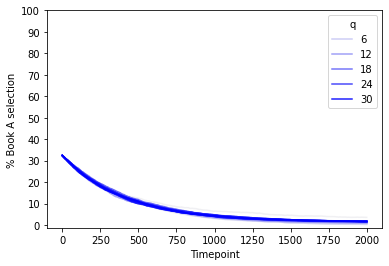

In [81]:
fig, ax = plt.subplots()
ax = sns.lineplot(data=df_q, x="timepoint", y="percentage", hue='q', palette='light:b')
ax.set_xlabel('Timepoint')
ax.set_ylabel('% Book A selection')
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

## Continuos Opinion models

### Deffuant

In [82]:
G = nx.from_pandas_edgelist(edge_list[edge_list['Weight']>1], 'Source', 'Target', ['Weight'])

In [83]:
model = op.AlgorithmicBiasModel(G)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("epsilon", 0.32)
config.add_model_parameter("gamma", 0)  # No bias = Deffuant
model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(100)

IndexError: index 494 is out of bounds for axis 0 with size 417